In [1]:
# -*- coding: utf-8 -*-
"""
Created on Thu Sep 21 15:52:58 2017

@author: meenakshi
"""

import os
import tarfile
from six.moves import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = "datasets/housing/"
HOUSING_URL = DOWNLOAD_ROOT + HOUSING_PATH + "housing.tgz"

def fetch_housing_data(housing_url = HOUSING_URL, housing_path = HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path = housing_path)
    housing_tgz.close()
    
fetch_housing_data(HOUSING_URL, HOUSING_PATH)

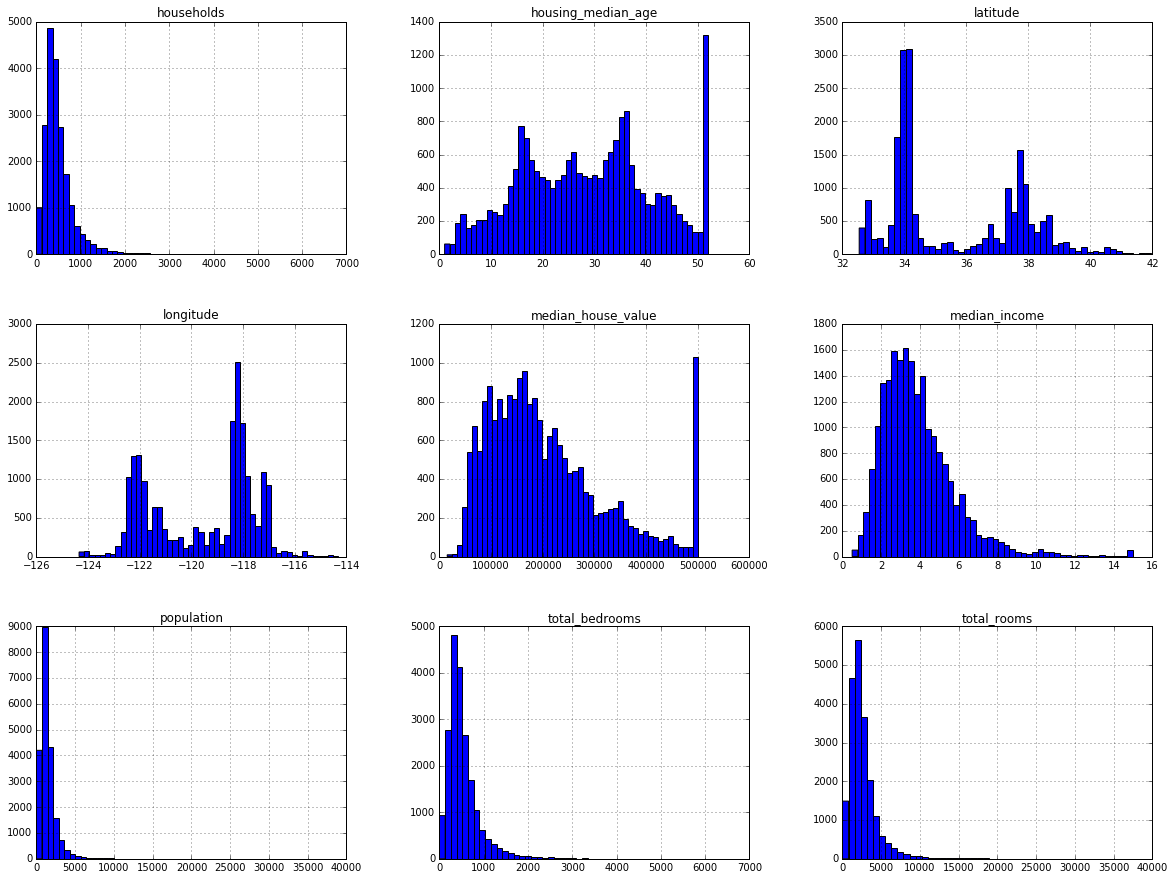

In [3]:
# -*- coding: utf-8 -*-
"""
Created on Thu Sep 21 16:14:51 2017

@author: meenakshi
"""

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import hashlib
from sklearn.model_selection import train_test_split

HOUSING_PATH = "datasets/housing/"

housing = pd.read_csv(HOUSING_PATH + "housing.csv")
housing.hist(bins = 50, figsize = (20,15))
plt.show()

def split_train_test(data, test_ratio):
    #np.random.seed(42) to fix the permutation for different runs
    shuffled_indices = np.random.permutation(len(data))
    test_size = int(len(data)*test_ratio)
    test_ind = shuffled_indices[:test_size]
    train_ind = shuffled_indices[test_size:]
    return data.iloc[test_ind], data.iloc[train_ind]
    
test_set, train_set = split_train_test(housing, 0.2)

def test_set_check(identifier, test_ratio, hash):
    return hash(np.int64(identifier)).digest()[-1] < 256*test_ratio
    
def test_train_split_hash(data, test_ratio, id_col, hash = hashlib.md5):
    ids = data[id_col]
    test_set_id = ids.apply(lambda idval:test_set_check(idval, test_ratio, hash))
    return data.loc[test_set_id], data.loc[~test_set_id]
    
housing.reset_index(inplace = True)

test_set, train_set = test_train_split_hash(housing, 0.2, "index")



